In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from hc_extension import *

In [2]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac_csvs"
brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

In [3]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn4-250121-084228/Notes.txt
read from t=0s to t=1861.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn7-250121-094048/Notes.txt
read from t=0s to t=1839.16s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn8-250121-101912/Notes.txt
read from t=0s to t=1836.57s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn6-250120-085156/Notes.txt
read from t=0s to t=1779.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn5-250120-081227/Notes.txt
read from t=0s to t=1772.86s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn1-250120-063024/Notes.txt
read from t=0s to t=1833.87s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohor

In [4]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...


## Total Investigation Time & Average Bout Duration

In [5]:
# cohort 3 nac
nn1 = experiment.trials['nn1-250120-063024']
nn2 = experiment.trials['nn2-250120-072910']
nn3 = experiment.trials['nn3-250121-074834']
nn4 = experiment.trials['nn4-250121-084228']
nn5 = experiment.trials['nn5-250120-081227']
nn6 = experiment.trials['nn6-250120-085156']
nn7 = experiment.trials['nn7-250121-094048']
nn8 = experiment.trials['nn8-250121-101912']

'''
# cohort 3 mpfc
nn1 = experiment.trials['pp1-250120-094415']
# nn2 = experiment.trials['nn2-250120-072910']
nn3 = experiment.trials['pp3-250121-055222']
nn4 = experiment.trials['pp4-250121-065035']
nn5 = experiment.trials['pp5-250121-110144']
nn6 = experiment.trials['pp6-250121-114116']
nn7 = experiment.trials['pp7-250121-134131']
nn8 = experiment.trials['pp8-250121-142227']
'''

# Read each CSV into a DataFrame
df1 = nn1.behaviors
df2 = nn2.behaviors
df3 = nn3.behaviors
df4 = nn4.behaviors
df5 = nn5.behaviors
df6 = nn6.behaviors
df7 = nn7.behaviors
df8 = nn8.behaviors
# df8 = nn8.behaviors

# Create a list of the DataFrames
trials = [df1, df2, df3, df4, df5, df6, df7, df8]

# Create one combined summary DataFrame (7 subjects total)
summary_df = create_subject_summary_df(trials)

# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7, nn8]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=0.5)


In [6]:
summary_df

,Bout,Behavior,Event_Start,Event_End,Duration (s),Subject,Total Investigation Time,Average Bout Duration
0,Long_Term-1,Approach,1468.4,1471.099,2.699,1,177.089,44.27225
1,Long_Term-1,Approach,1571.6,1572.999,1.399,1,177.089,44.27225
2,Long_Term-1,Investigation,1471.1,1473.200,2.100,1,177.089,44.27225
3,Long_Term-1,Investigation,1481.0,1484.200,3.200,1,177.089,44.27225
4,Long_Term-1,Investigation,1503.8,1506.300,2.500,1,177.089,44.27225
...,...,...,...,...,...,...,...,...
339,Short_Term-2,Investigation,1625.4,1625.800,0.400,8,169.295,42.32375
340,Short_Term-2,Investigation,1633.0,1633.200,0.200,8,169.295,42.32375
341,Short_Term-2,Investigation,1643.4,1644.100,0.700,8,169.295,42.32375
342,Short_Term-2,Investigation,1766.1,1766.600,0.500,8,169.295,42.32375


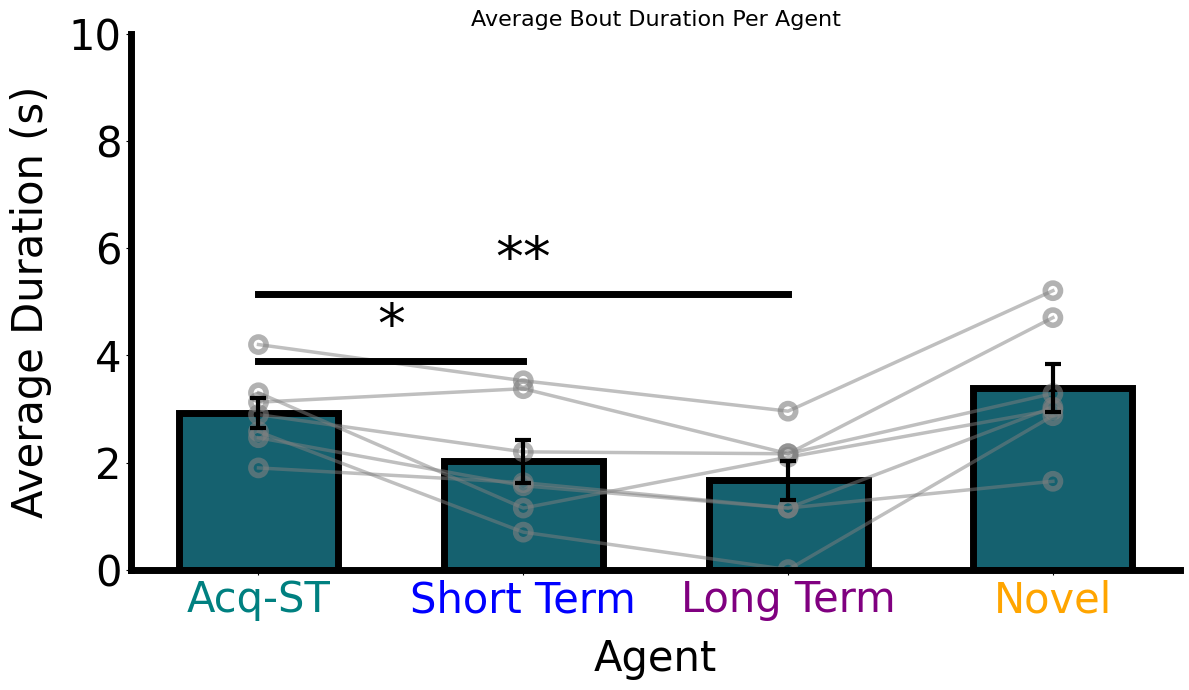

In [7]:
# --- Filter Summary DataFrame by Specific Bouts ---
desired_bouts = ["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# get rid of 5
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]

# Group by Subject and Bout and sum Duration (s) to ensure unique pairs
grouped_df = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()

# Pivot the grouped DataFrame so that rows are subjects and columns are bouts
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # Fill missing values with 0

# Define the desired order of the bars
desired_order = ["Acq-ST", "Short Term", "Long Term", "Novel"]

# Map original bout names to new labels
bout_rename_mapping = {
    "Short_Term-1": "Acq-ST",
    "Short_Term-2": "Short Term",
    "Long_Term-1": "Long Term",
    "Novel-1": "Novel"
}

# Rename columns in pivot_df
pivot_df = pivot_df.rename(columns=bout_rename_mapping)

# Reorder columns based on desired order
pivot_df = pivot_df[desired_order]  # This ensures the bars are plotted in this order

# Then call your plotting function
plot_y_across_bouts_gray(
    df=pivot_df,
    title="Average Bout Duration Per Agent",
    ylabel="Average Duration (s)",
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(0, 10),
    bar_color=brain_region,
    yticks_increment=2,
    xlabel="Agent",
    figsize=(12,7),
    pad_inches=0.1
)

## Global DA

In [9]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first = True)

# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(
    use_fractional=True,       # Enable fractional analysis (limits window to max_bout_duration)
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    peak_fall_fraction=0.6,    # Set the fall threshold to 60% of the peak
    allow_bout_extension=True, # Allow extending the bout window if needed
    first=None                 # Consider only the first investigation event per bout
)

Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...
Computing DA metrics for nn4-250121-084228 ...
Computing DA metrics for nn7-250121-094048 ...
Computing DA metrics for nn8-250121-101912 ...
Computing DA metrics for nn6-250120-085156 ...
Computing DA metrics for nn5-250120-081227 ...
Computing DA metrics for nn1-250120-063024 ...
Computing DA metrics for nn3-250121-074834 ...
Computing DA metrics for nn2-250120-072910 ...


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

def plot_da_metrics_combined_oneplot_integrated(experiment, 
                                                metric_name="Mean Z-score", 
                                                title="Combined DA Metrics", 
                                                ylabel="DA Metric", 
                                                xlabel="Bout", 
                                                custom_xtick_labels=None, 
                                                custom_xtick_colors=None, 
                                                ylim=None, 
                                                bar_color="#00B7D7", 
                                                yticks_increment=None, 
                                                figsize=(14,8), 
                                                pad_inches=0.1):
    """
    Plots DA metrics across specific bouts for all trials in the experiment.
    If p-value < 0.05, it adds a horizontal significance line + asterisk above bars.

    Updates:
    - Unfilled circle markers for individual trials
    - Thick grey outlines for visibility
    """

    def perform_t_tests(pivot_df):
        """Performs paired t-tests comparing Acq-ST with Short Term, Long Term, and Novel."""
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }

        results = {}

        for key, (bout1, bout2) in comparisons.items():
            if bout1 in pivot_df.columns and bout2 in pivot_df.columns:
                paired_df = pivot_df[[bout1, bout2]].dropna()
                
                if len(paired_df) > 1:
                    t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        
        return results

    # Collect per-trial data for the chosen metric
    trial_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            trial_df = trial.behaviors.copy()
            if metric_name not in trial_df.columns:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'. Skipping.")
                continue
            df_grouped = trial_df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name
            trial_data.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")

    if not trial_data:
        print("No data available to plot.")
        return

    # Combine all trial data into a single DataFrame.
    combined_df = pd.concat(trial_data, ignore_index=True)

    # Select only 6 bouts
    selected_bouts = combined_df["Bout"].unique()[:6]
    combined_df = combined_df[combined_df["Bout"].isin(selected_bouts)]

    # Pivot the data for line plots: rows=Trial, columns=Bout, values=metric_name
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name).fillna(0)
    except Exception as e:
        print("Error pivoting data for line plots:", e)
        return

    # Compute overall average and SEM for each Bout
    overall_stats = combined_df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()

    # Now that pivot_df is created, perform t-tests
    t_test_results = perform_t_tests(pivot_df)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the overall average as a bar chart with error bars
    ax.bar(overall_stats["Bout"], overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))
    
    # Overlay individual trial lines (all in gray)
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], linestyle='-', color='gray', 
                alpha=0.5, linewidth=3, marker='o', markerfacecolor='none', 
                markeredgecolor='gray', markeredgewidth=2, markersize=10)

    # Set labels and title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=28)

    # Set exactly 6 x-tick labels
    xtick_labels = ["i1", "i1", "i1", "i1", "i1", "i2"]
    xtick_colors = ["blue", "blue", "blue", "blue", "blue", "#E06928"]

    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(xtick_labels, fontsize=28)

    # Apply custom colors
    for tick, color in zip(ax.get_xticklabels(), xtick_colors):
        tick.set_color(color)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)
    
    # Set y-limits
    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        ax.set_ylim(0, np.nanmax(all_values) * 1.2)
    else:
        ax.set_ylim(ylim)

    # Set y-ticks increment
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment))

    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # ---- Plot significance markers ---- #
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05  # Offset above bars

        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }

        line_spacing = sig_y_offset * 2.5  # Adjust spacing between lines
        current_y = np.nanmax(overall_stats["mean"]) + sig_y_offset  # Initial line position

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*" 

                    # Draw horizontal line
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)

                    # Add asterisks centered above the line
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance, 
                            fontsize=40, ha='center', color='black')

                    # Move the next line slightly higher to avoid overlap
                    current_y += line_spacing

    plt.tight_layout(pad=pad_inches)
    plt.show()


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (6).

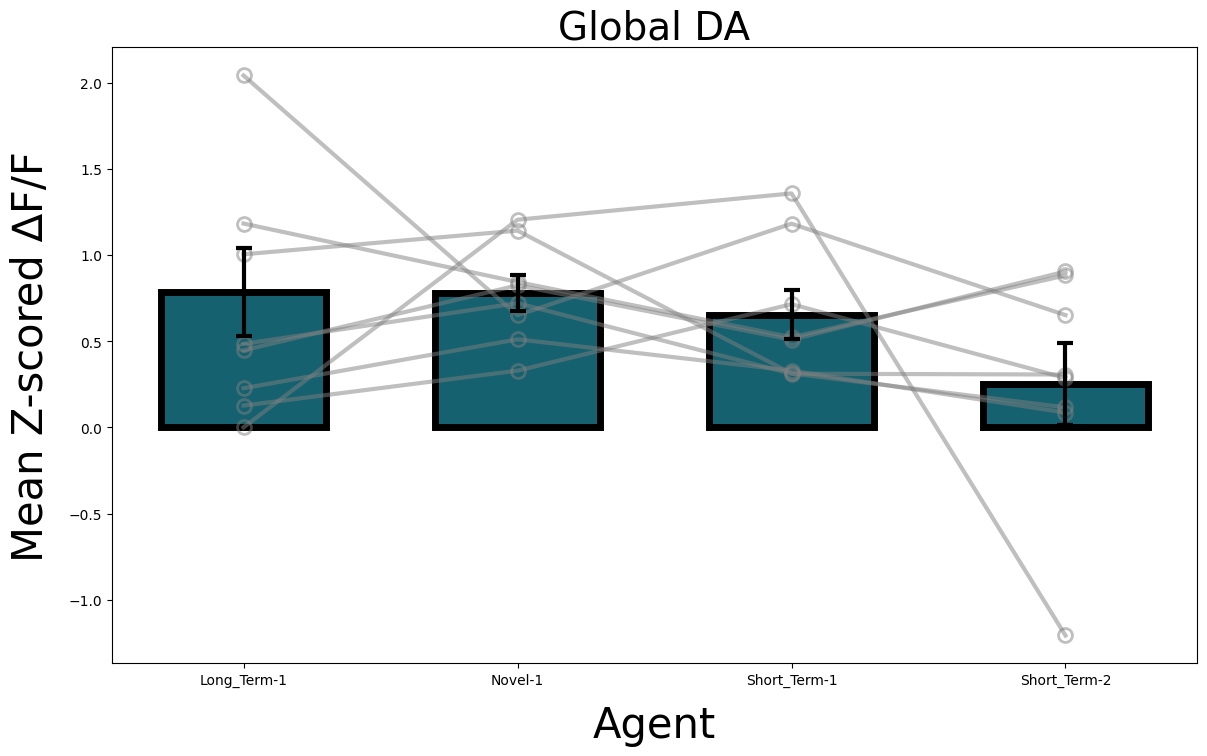

In [20]:
from scipy.stats import ttest_rel

plot_da_metrics_combined_oneplot_integrated(experiment, 
                                                metric_name="Mean Z-score", 
                                                title="Global DA", 
                                                ylabel="Mean Z-scored ∆F/F", 
                                                xlabel="Agent", 
                                                custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                                                custom_xtick_colors=["teal", "blue", "purple", "orange"], 
                                                ylim=(0, 10), 
                                                bar_color=brain_region, 
                                                yticks_increment=2, 
                                                figsize=(14,8), 
                                                pad_inches=0.1)

# Mean Z-scored ∆F/F